# Alzheimer’s Disease Prediction by Machine Learning Models with MRI Images

### Importing Libraries

In [1]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from PIL import Image

from skimage.feature import graycomatrix, graycoprops
import skimage.feature as feature

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

### Loading The Dataset

Since the dataset consists of lots of MRI images, I decided to upload them by using Kaggle API.

In [2]:
dataset_url = "https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset"
od.download(dataset_url)

Skipping, found downloaded files in "./alzheimer-mri-dataset" (use force=True to force download)


### Dataset Analysis

In [3]:
#Dataset directory
dataset_dir = "./alzheimer-mri-dataset/Dataset"
print(os.listdir(dataset_dir))

files = os.listdir(dataset_dir)
print(f"Number of labels is {len(files)} in this dataset.")

['Moderate_Demented', 'Mild_Demented', 'Very_Mild_Demented', 'Non_Demented']
Number of labels is 4 in this dataset.


As we can see there are four groups of images in the dataset such as 'Moderate_Demented', 'Mild_Demented', 'Very_Mild_Demented' and 'Non_Demented'.

In [4]:
total_images = 0
label_counts = {}
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):
        num_images = len(os.listdir(label_dir))
        total_images += num_images
        label_counts[label] = num_images
        print(f"Number of images in {label} folder: {num_images}")

print(f"Total number of images in the dataset: {total_images}")

Number of images in Moderate_Demented folder: 664
Number of images in Mild_Demented folder: 896
Number of images in Very_Mild_Demented folder: 1240
Number of images in Non_Demented folder: 1200
Total number of images in the dataset: 4000


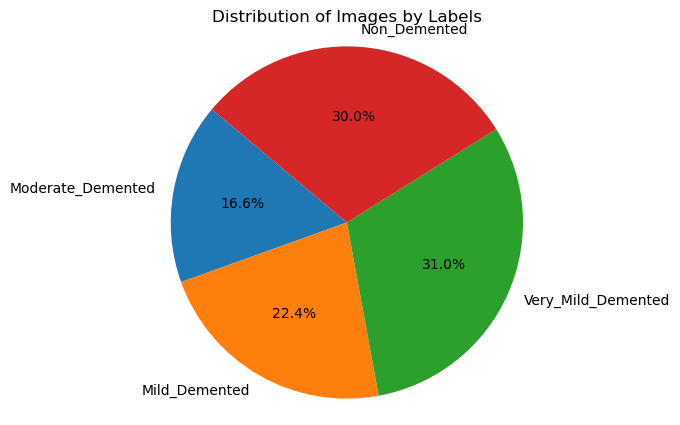

In [5]:
plt.figure(figsize=(5, 5))
plt.pie(label_counts.values(), labels=label_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images by Labels')
plt.axis('equal')
plt.show()

In [6]:
def visualise_images(path, label, num_samples= 5):
    label_dir = os.path.join(path, label)
    image_files = os.listdir(label_dir)
    random_samples = random.sample(image_files, min(num_samples, len(image_files)))
    
    plt.figure(figsize=(20, 4))
    for i, image_file in enumerate(random_samples):
        img_path = os.path.join(label_dir, image_file)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{label} Image {i+1}')
        plt.axis('off')
    plt.show()

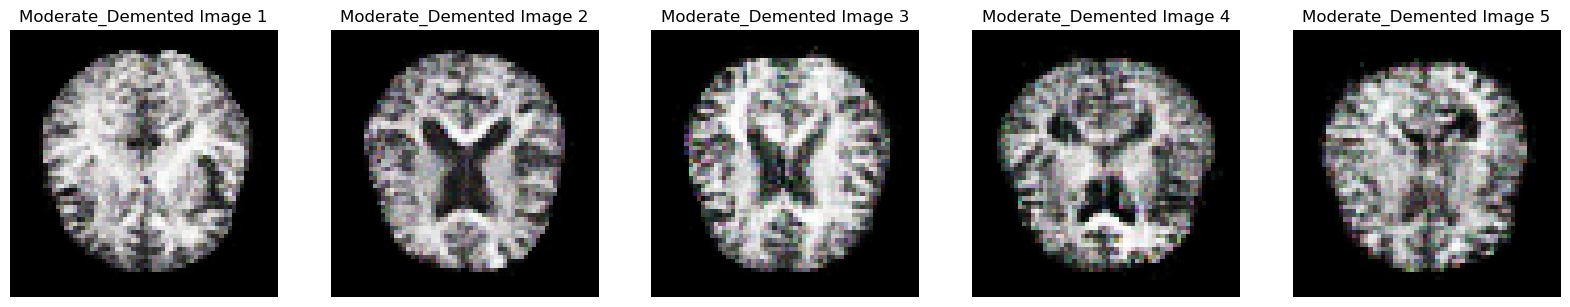

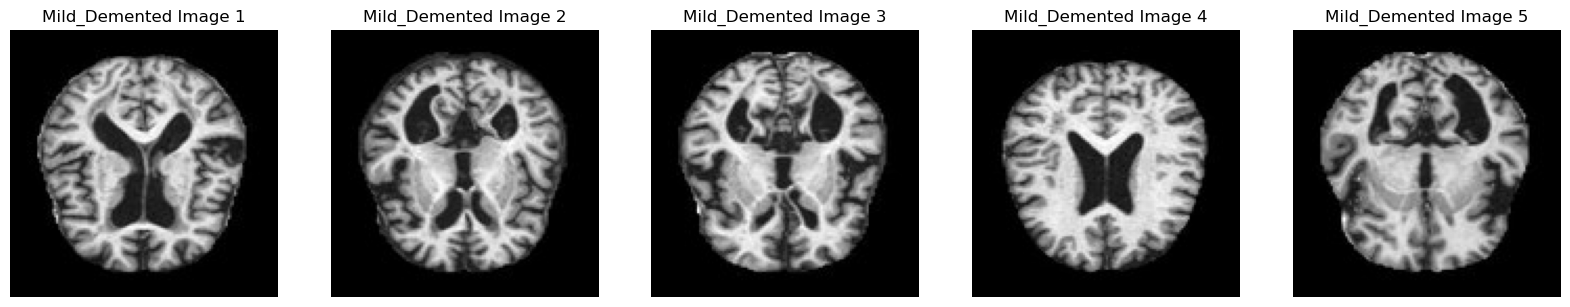

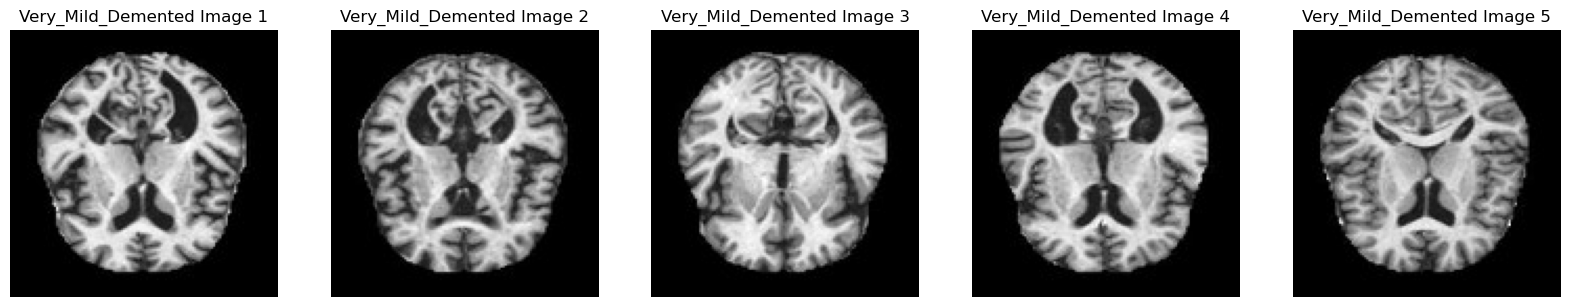

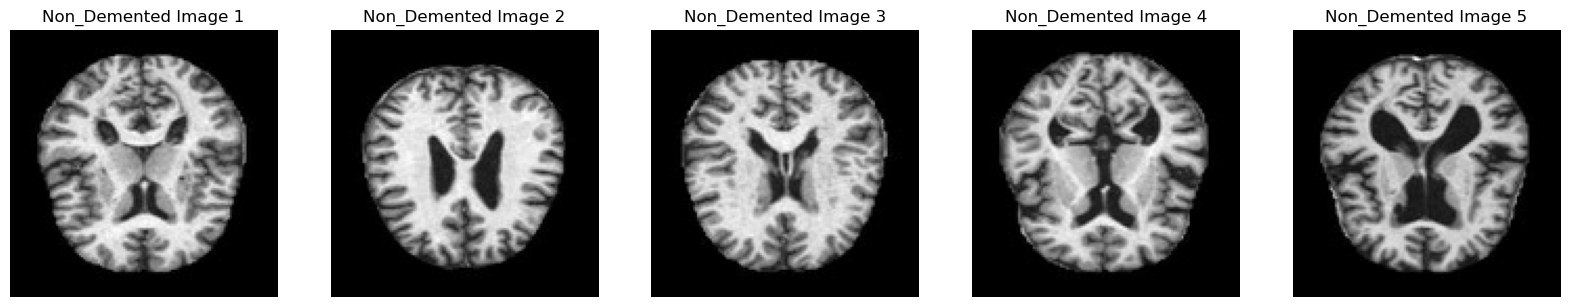

In [7]:
labels = os.listdir(dataset_dir)
for label in labels:
    visualise_images(dataset_dir, label)

### Dataset Preprocessing

#### Resize

Each image in the dataset needs to have the same size—that is, 128 × 128. Even though the images that were chosen randomly have the same size, it is still important to review the data set and make any modifications that are required.

In [8]:
def resize_images(path, label, size=(128,128)):
    label_dir = os.path.join(path, label)
    for image_file in os.listdir(label_dir):
        img_path = os.path.join(label_dir, image_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img.shape != size:
            img_resized = cv2.resize(img, size)
            cv2.imwrite(img_path, img_resized) 

In [9]:
labels = os.listdir(dataset_dir)
for label in labels:
    resize_images(dataset_dir, label)
    if resize_images(dataset_dir, label):
        print(f"Images resized in {label}.")
    else:
        print(f"None of the images needed to be resized in {label}.")

None of the images needed to be resized in Moderate_Demented.
None of the images needed to be resized in Mild_Demented.
None of the images needed to be resized in Very_Mild_Demented.
None of the images needed to be resized in Non_Demented.


### Data Augmentation

There is a significant imbalance in the data set, as we have already analysed.  A greater number of images have been included in some labels than others. It has been decided to use the Generative Model to perform augmentation to prevent any potential problems that this situation might cause. 

#### DCGAN

In [ ]:
#parameters
img_width, img_height = 128, 128
batch_size=32
latent_dim = 128
epochs = 60

In [ ]:
#directories
img_generator = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True)
#Main Data
dataset = img_generator.flow_from_directory(
    dataset_dir,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    class_mode='categorical'
)
#Moderate Data
moderate_demented = img_generator.flow_from_directory(
    dataset_dir,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    classes=['Moderate_Demented']
)

In [ ]:
#Display random image from 'Moderate_Demented' class
moderate_dataset = os.path.join(dataset_dir, 'Moderate_Demented')
moderate_images = os.listdir(moderate_dataset)

img_name = np.random.choice(moderate_images)
img_path = os.path.join(moderate_dataset, img_name)

img = plt.imread(img_path)
img_name = os.path.splitext(img_name)[0]

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(img_name)
plt.show()

In [ ]:
dataset_train = keras. utils.image_dataset_from_directory(
    dataset_dir,
    batch_size = batch_size,
    image_size = (img_width, img_height))

data_iterator = dataset_train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(10,10))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
train_gen = img_generator.flow_from_directory(
        dataset_dir,
        target_size = (64, 64),
        batch_size = batch_size,
        class_mode = None)

In [ ]:
#Generator
def generator_model():
    generator = tf.keras.Sequential([
        layers.Dense(8 * 8 * 256, input_dim=latent_dim),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
    ])
    return generator

generator = generator_model()
generator.summary()

In [ ]:
#Discriminator
def discriminator_model():
    discriminator = tf.keras.Sequential([
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(64, 64, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return discriminator

discriminator = discriminator_model()
discriminator.summary()

In [ ]:
class DCGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super(DCGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

        # loss metrics
        self.d_loss_metric = tf.keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = tf.keras.metrics.Mean(name='g_loss')


    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
        
        
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        
        # Train discriminator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    
        generated_images = self.generator(random_latent_vectors)
    
        combined_images = tf.concat([generated_images, real_images], axis=0)
    
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))  # Adding noise to labels

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Train generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors)
            predictions = self.discriminator(generated_images)
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": d_loss, "g_loss": g_loss}


In [ ]:
#Monitor and saving images
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, latent_dim=128, num_images=10, output_dir='./alzheimer-mri-dataset/Dataset/Moderate_Demented'):
        self.latent_dim = latent_dim
        self.num_images = num_images
        self.output_dir = output_dir

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_images, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

        for i in range(self.num_images):
            img = keras.utils.array_to_img(generated_images[i])
            img_path = os.path.join(self.output_dir, f"generated_img_{epoch:03d}_{i}.png")
            img.save(img_path)

In [ ]:
dcgan_monitor = DCGANMonitor(output_dir='./alzheimer-mri-dataset/Dataset/Moderate_Demented')

dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim = latent_dim)
dcgan.compile(g_optimizer = Adam (learning_rate= 0.0001, beta_1= 0.0001), d_optimizer= Adam (learning_rate = 0.0001 , beta_1= 0.0001), loss_fn = BinaryCrossentropy())

# fit the model and save the history
history = dcgan.fit(train_gen, epochs=epochs, callbacks=[DCGANMonitor()])

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(5):
    plt.subplot(6, 6, i + 1)
    noise = tf.random.normal([1, 128])
    mg = dcgan.generator(noise)
    
    #denormalize
    mg = (mg * 255) + 255
    mg.numpy()
    image = Image.fromarray(np.uint8(mg[0]))

    plt.imshow(image)
    plt.axis('off')

plt.show()

After successfully finishing the data augmentation stage, we chose to randomly choose a number of images loaded with data folders to balance the distribution of labels in the dataset.

In [ ]:
#To balance the dataset deleting the images from some folders
def delete_images(label_dir, num_images):
   
    images = os.listdir(label_dir)
    num_images = min(num_images, len(images))

    images_to_delete = random.sample(images, num_images)
    for image in images_to_delete:
        image_path = os.path.join(label_dir, image)
        os.remove(image_path)

non_demented_dir = os.path.join(dataset_dir, "Non_Demented")
very_mild_demented_dir = os.path.join(dataset_dir, "Very_Mild_Demented")

num_delete_nd = 2000
num_delete_vmd = 1000
delete_images(non_demented_dir, num_delete_nd)
delete_images(very_mild_demented_dir, num_delete_vmd)

In [ ]:
folders = os.listdir(dataset_dir)
folder_image_count = {}
for folder in folders:
    folder_path = os.path.join(dataset_dir, folder)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        folder_image_count[folder] = len(images)

#distribution using a pie chart
plt.figure(figsize=(8, 6))
plt.pie(folder_image_count.values(), labels=folder_image_count.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images per Folder')
plt.axis('equal')
plt.show()

print("Number of Images in Each Folder:")
for folder, count in folder_image_count.items():
    print(f"{folder}: {count} images")

As we can see in the piechart, the dataset is not more balanced and ready to be worked with.

### Grey Level Co-occurrence Matrix (GLCM)

In [10]:
#Create dataframe from the dataset
def create_dataframe(dataset_dir):
    data = []
    for label in os.listdir(dataset_dir):
        label_dir = os.path.join(dataset_dir, label)
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_file)
                data.append({'image_path': image_path, 'label': label})
    df = pd.DataFrame(data)
    return df

In [11]:
dataset_dir = "./alzheimer-mri-dataset/Dataset"
df_glcm = create_dataframe(dataset_dir)
df_glcm

,image_path,label
0,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
1,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
2,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
3,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
4,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
...,...,...
3995,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented
3996,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented
3997,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented
3998,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented


In [12]:
#Function for calculate GLCM features
def calculate_glcm(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    glcm = graycomatrix(img, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)

    #properties
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    return contrast, dissimilarity, homogeneity, energy, correlation

In [13]:
def df_with_glcm(df):

    glcm_properties = df['image_path'].apply(calculate_glcm)
    df[['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']] = pd.DataFrame(glcm_properties.tolist(), index=df.index)
    return df

dataset_dir = "./alzheimer-mri-dataset/Dataset"
df_glcm = create_dataframe(dataset_dir)
df_glcm = df_with_glcm(df_glcm)
df_glcm

,image_path,label,contrast,dissimilarity,homogeneity,energy,correlation
0,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,162.014026,6.838706,0.526976,0.477714,0.979817
1,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,179.770915,7.351009,0.492898,0.414324,0.988211
2,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,170.011319,7.350025,0.486353,0.423006,0.986252
3,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,149.375861,6.511688,0.522309,0.450900,0.988246
4,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,159.988189,7.171383,0.481416,0.417769,0.985728
...,...,...,...,...,...,...,...
3995,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented,355.366880,9.789493,0.456729,0.390447,0.974058
3996,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented,324.593504,9.934670,0.449123,0.393315,0.976762
3997,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented,319.061270,9.484375,0.469609,0.406274,0.979710
3998,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented,288.404897,9.230192,0.460310,0.394544,0.980104


In [17]:
X = df_glcm.iloc[:,2:7]
y = df_glcm['label']

X

,contrast,dissimilarity,homogeneity,energy,correlation
0,162.014026,6.838706,0.526976,0.477714,0.979817
1,179.770915,7.351009,0.492898,0.414324,0.988211
2,170.011319,7.350025,0.486353,0.423006,0.986252
3,149.375861,6.511688,0.522309,0.450900,0.988246
4,159.988189,7.171383,0.481416,0.417769,0.985728
...,...,...,...,...,...
3995,355.366880,9.789493,0.456729,0.390447,0.974058
3996,324.593504,9.934670,0.449123,0.393315,0.976762
3997,319.061270,9.484375,0.469609,0.406274,0.979710
3998,288.404897,9.230192,0.460310,0.394544,0.980104


In [18]:
#Machine Learning function
def ml_models(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

# Evaluating the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    accuracy = classification_report(y_test, y_pred)
    print("classification_report:", accuracy)

In [19]:
#RANDOM FOREST
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=10)
ml_models(rf_model, X, y)

Accuracy: 0.63
classification_report:                     precision    recall  f1-score   support

     Mild_Demented       0.51      0.57      0.54       189
 Moderate_Demented       0.99      0.87      0.93       147
      Non_Demented       0.67      0.59      0.62       218
Very_Mild_Demented       0.52      0.57      0.54       246

          accuracy                           0.63       800
         macro avg       0.67      0.65      0.66       800
      weighted avg       0.65      0.63      0.64       800



In [20]:
#GAUSSIAN NB
gnb_model = GaussianNB()
ml_models(gnb_model, X, y)

Accuracy: 0.49625
classification_report:                     precision    recall  f1-score   support

     Mild_Demented       0.38      0.63      0.48       189
 Moderate_Demented       0.81      0.88      0.84       147
      Non_Demented       0.45      0.61      0.52       218
Very_Mild_Demented       0.48      0.06      0.11       246

          accuracy                           0.50       800
         macro avg       0.53      0.55      0.49       800
      weighted avg       0.51      0.50      0.44       800



In [21]:
#DECISION TREE
dt_model = DecisionTreeClassifier()
ml_models(dt_model, X, y)

Accuracy: 0.5625
classification_report:                     precision    recall  f1-score   support

     Mild_Demented       0.50      0.48      0.49       189
 Moderate_Demented       0.95      0.88      0.92       147
      Non_Demented       0.50      0.50      0.50       218
Very_Mild_Demented       0.46      0.49      0.47       246

          accuracy                           0.56       800
         macro avg       0.60      0.59      0.59       800
      weighted avg       0.57      0.56      0.57       800



In [22]:
#SVM
svm_model = SVC(kernel='linear', random_state=42)
ml_models(svm_model, X, y)

Accuracy: 0.48625
classification_report:                     precision    recall  f1-score   support

     Mild_Demented       0.38      0.02      0.03       189
 Moderate_Demented       0.89      0.89      0.89       147
      Non_Demented       0.42      0.44      0.43       218
Very_Mild_Demented       0.38      0.64      0.48       246

          accuracy                           0.49       800
         macro avg       0.52      0.50      0.46       800
      weighted avg       0.48      0.49      0.44       800



In [23]:
#LOGISTIC REGRESSION
lr_model = LogisticRegression(max_iter=1000, random_state=42)
ml_models(lr_model, X, y)

Accuracy: 0.455
classification_report:                     precision    recall  f1-score   support

     Mild_Demented       0.33      0.10      0.15       189
 Moderate_Demented       0.84      0.88      0.86       147
      Non_Demented       0.37      0.39      0.38       218
Very_Mild_Demented       0.36      0.53      0.43       246

          accuracy                           0.46       800
         macro avg       0.48      0.48      0.46       800
      weighted avg       0.45      0.46      0.43       800



In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import sys, cv2, glob, os, time,re,string
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [25]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(128,128)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(labels)
    
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

In [26]:
#Train data
Images, Labels = get_images("./alzheimer-mri-dataset/Dataset/") #Extract the training images from the folders.

Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels)

In [27]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels
encoded_labels = label_encoder.fit_transform(Labels)



In [28]:
X_train, X_test, y_train, y_test = train_test_split(Images, encoded_labels, test_size=0.2, random_state=42)

In [29]:
from collections import Counter
Counter(encoded_labels)

Counter({3: 1240, 2: 1200, 0: 896, 1: 664})

In [34]:
model = tf.keras.models.Sequential(name="DeepReLUwithEfficientNetB0")
model.add(tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(128, 128, 3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.layers[0].trainable = False
model.summary()

Model: "DeepReLUwithEfficientNetB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 flatten_2 (Flatten)         (None, 20480)             0         
                                                                 
 dense_10 (Dense)            (None, 4096)              83890176  
                                                                 
 dense_11 (Dense)            (None, 1024)              4195328   
                                                                 
 dense_12 (Dense)            (None, 256)               262400    
                                                                 
 dense_13 (Dense)            (None, 64)                16448     
                                                                 
 dense_14 (Dense)            (None, 4)  

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
training_history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100)

Epoch 1/100
100/100 [==============================] - 38s 359ms/step - loss: 1.0057 - accuracy: 0.5263 - val_loss: 0.9590 - val_accuracy: 0.5150
Epoch 2/100
100/100 [==============================] - 31s 308ms/step - loss: 0.8332 - accuracy: 0.5997 - val_loss: 0.7540 - val_accuracy: 0.6438
Epoch 3/100
100/100 [==============================] - 27s 269ms/step - loss: 0.7764 - accuracy: 0.6366 - val_loss: 0.6961 - val_accuracy: 0.7025
Epoch 4/100
100/100 [==============================] - 2784s 28s/step - loss: 0.7071 - accuracy: 0.6716 - val_loss: 0.6274 - val_accuracy: 0.7000
Epoch 5/100
100/100 [==============================] - 1889s 19s/step - loss: 0.6483 - accuracy: 0.7153 - val_loss: 0.6250 - val_accuracy: 0.7200
Epoch 6/100
100/100 [==============================] - 33s 326ms/step - loss: 0.6054 - accuracy: 0.7384 - val_loss: 0.6508 - val_accuracy: 0.7200
Epoch 7/100
100/100 [==============================] - 29s 290ms/step - loss: 0.5738 - accuracy: 0.7437 - val_loss: 0.5849 -